# Text Detection for PicTex 
### Pytorch Docs Edition
by Len Huang

An exploratory notebook to learn `PyTorch`. Following https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Note that much of the text below is copied / modified from the above article. I do not intend to use this for any copyright infrigement, only educational purposes. 

Much of the additional content is also learned from the Deep Lizard full course: https://deeplizard.com/learn/video/v5cngxo4mIg

**I have rewritten much of the code as functions instead of running them directly so that we can run them all together at the end. This personally made more sense to me, and allowed for deeper discussion of each part of the code.**

The steps we will take include 

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

First import the necessary packages:

In [2]:
# Torch tings
import torch
import torchvision
import torchvision.transforms as transforms
# Math tings
import matplotlib.pyplot as plt
import numpy as np
# CNN tings
import torch.nn as nn
import torch.nn.functional as F
# loss / optimize tings
import torch.optim as optim

### 1. Load and normalizing CIFAR10

CIFAR10 is a common dataset used for image training. Other ones include Imagenet, MNIST. We're going to want to load this data into a `numpy` array so that we can work with it. These are represented as `PILImage` images of range [0,1], so we want to trasform them to Tensors of range [-1,1].

_(Len) I briefly discuss what some of these functions do, but more detail is available here:_
- https://pytorch.org/docs/master/torchvision/transforms.html 
- https://pytorch.org/docs/stable/data.html
- https://pillow.readthedocs.io/en/stable/reference/Image.html

In [3]:
# These imports are used here
# import torch
# import torchvision
# import torchvision.transforms as transforms

def load_data():
    # Composes multiple transformations together
    # .ToTensor() converts a PIL Image / numpy arrray to a tensor
    # A tensor is a multidimensional matrix containing elements of a single data type
    # .Normalize(mean,std,inplace=False) normalizes a tensor image with mean and std dev
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Download the premade training dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # DataLoaders take in a "dataset" class and give us an iterable. 
    # Makes datasets easier to work with
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                              shuffle=True, num_workers=2)

    # Same thing with the test set
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Same thing with the test loader
    testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                             shuffle=False, num_workers=2)

    # Define our classes that we'll be testing
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    return trainloader, testloader, classes

This can help us show images in this dataset. More documentation available here: https://pytorch.org/docs/stable/torchvision/utils.html

In [4]:
# These imports are used here
# import matplotlib.pyplot as plt
# import numpy as np

def show_image():
    # Function to show an image
    def imshow(img):
        img = img / 2 + 0.5 # unnormalize
        npimg = img.numpy() # numpy-ify image
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    # get some random training images
    # example of how DataLoaders make things easier
    # iter() and .next() act like loops i think?
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Given a tensor or a list of image tensors, make a grid of images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
    return imshow

### 2. Define a Convolutional Neural Network

In the previous section, Neural Networks were defined: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

These will work for one channel images. We're going to copy this but modify it for three chanenel images. 

Channel refers to RGB (a red channel, green channel, blue channel). One channel refers to grayscale images.

Here are some good videos that I've been watching _(Len)_
- Deep Lizard video on what CNN's are: https://www.youtube.com/watch?v=YRhxdVk_sIs
- Deep Lizard video on PyTorch Usage (Layers): https://www.youtube.com/watch?v=IKOHHItzukk
- Deep Lizard video on PyTorch Usage (Weights): https://www.youtube.com/watch?v=stWU37L91Yc

#### Len's Notes from the Videos:
`nn.Conv2d(x,y,z)` ==> "Applies a 2D convolution over an input signal composed of several input planes" [_(from docs)_](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html). These parameters directly influence the weights in the backend implementation of the tensors. _(Not 100% what this means)._
- `x = 3` refers to the `in_channel`, or the number of channels in an input image (1 for grayscale, 3 for color).
- `y = 6` refers to the `out_channels`, or the number of outputs produced by the `y` number of filters. (This also sets the number of filters!) Commonly referred to as **feature maps** or just *features* for `Linear` layers. This should be equal to the number of classes you're predicting.
- `z = 5` refers to the `kernel_size`, or the size of the filter that we'll be using.

`nn.Linear(x,y)` ==> "Applies a linear transformation to the incoming data: $y=xA^T+b$"
- `x = 16 * 5 * 5` refers to the `in_features`, or the size of each input sample.
- `y = 120` refers to the `out_features`, or the size of each output sample. Like `out_channels` this is the number of `classes` that you're predicting.

**Layer Trends:** For `Conv2d` layers, we increase the `out_channels` as we increase layers. For `Linear` layers, we decerase the `out_features` as we increase layers.

`nn.MaxPool2d(x,y)` ==> "Applies a 2D max pooling over an input signal composed of several input planes."
- `x = 2` refers to the `kernel_size`, or the size of the window to take a max over.
- `y = 2` refers to the `stride`, or the stride of the window.
- Note: _(I have no idea what this means, this wasn't in the video but is in the PyTorch Blitz)_

`def forward()` ==> "This method is the actual network transformation. The forward method is the mapping that maps an input tensor to a prediction output tensor."

In [14]:
# These imports are used here
# import torch.nn as nnhttps://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
# import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2) # idk what this does
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Transitioning from Conv ===> Linear
        # 16 is the number of output channels in the previous conv layer.
        # not sure what 5 is...
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# init the class 
# net = Net()

### 3. Define a loss function and optimizer

![](https://i.imgflip.com/2g4kix.jpg)

Let’s use a Classification Cross-Entropy loss and SGD with momentum.
- Cross-Entropy: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
- Stochastic Gradient Descent (SGD): https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum
- Torch Optimizers: https://pytorch.org/docs/stable/optim.html
- Learning Rate: https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

In [15]:
# This import is used here
# import torch.optim as optim

def loss_optim():
    criterion = nn.CrossEntropyLoss()
    # Adam
    # optimizer = optim.Adam(net.parameters(), lr=0.001)
    # SGD. Momentum = remembering previous estimation change for a param (delta W)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    return criterion, optimizer

### 4. Train the network

Loop over the data iterator, feed inputs to network, and optimize

In [16]:
def train_network():
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    PATH = './torch_model.pth'
    torch.save(net.state_dict(), PATH)
    print('Finished Training')

### 5. Test the network on the test data

In [17]:
def test_data():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Putting It All Together

Files already downloaded and verified
Files already downloaded and verified


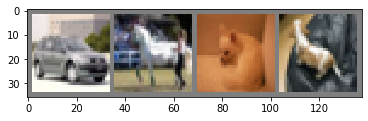

  car horse   dog   dog
[1,  2000] loss: 2.267
[1,  4000] loss: 1.889
[1,  6000] loss: 1.656
[1,  8000] loss: 1.567
[1, 10000] loss: 1.500
[1, 12000] loss: 1.463
[2,  2000] loss: 1.401
[2,  4000] loss: 1.378
[2,  6000] loss: 1.348
[2,  8000] loss: 1.341
[2, 10000] loss: 1.314
[2, 12000] loss: 1.296
Finished Training


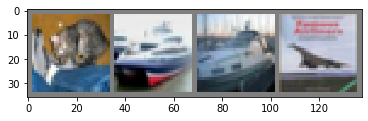

GroundTruth:    cat  ship  ship plane


In [18]:
trainloader, testloader, classes = load_data()
net = Net()
imshow = show_image()
criterion, optimizer = loss_optim()
train_network()
test_data()

In [22]:
1+1

2